# Predicting the returns of stocks

The goal is to predict the returns of stocks of tomorrow, and use that as part of a trading strategy.

Trading strategy:
- Everyday, after the market is closed, we predict the returns of tomorrow (batch-processing for all 10 of our stocks). If for a given stock, the returns we predict for tomorrow exceed a certain threshhold (here we are using 0 as the threshold), we buy the stock when the market opens, and we sell it when the market closes.   
   
Models:
- Dummy Regressor (average of training set)
- XGBoost model of lagged values sentiment of relevant news, and technical indicators.
- LSTM (recurrent neural networks)

### Loading Libraries

In [162]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, \
        accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBRegressor, plot_importance
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

### Importing the Data

#### 1. For the dummy regressor

In [163]:
df_cdipa_dummy = pd.read_csv('data\\processed\\cdipa_dummy.csv')
df_cfrsw_dummy = pd.read_csv('data\\processed\\cfrsw_dummy.csv')
df_lulu_dummy = pd.read_csv('data\\processed\\lulu_dummy.csv')
df_mcpa_dummy = pd.read_csv('data\\processed\\mcpa_dummy.csv')
df_moncmi_dummy = pd.read_csv('data\\processed\\moncmi_dummy.csv')
df_pndoraco_dummy = pd.read_csv('data\\processed\\pndoraco_dummy.csv')
df_rl_dummy = pd.read_csv('data\\processed\\rl_dummy.csv')
df_rmspa_dummy = pd.read_csv('data\\processed\\rmspa_dummy.csv')
df_uhrsw_dummy = pd.read_csv('data\\processed\\uhrsw_dummy.csv')
df_vfc_dummy = pd.read_csv('data\\processed\\vfc_dummy.csv')

Converting the Date to datetime format and setting it as index.

In [ ]:
df_cdipa_dummy['Date'] = pd.to_datetime(df_cdipa_dummy['Date'])
df_cfrsw_dummy['Date'] = pd.to_datetime(df_cfrsw_dummy['Date'])
df_lulu_dummy['Date'] = pd.to_datetime(df_lulu_dummy['Date'])
df_mcpa_dummy['Date'] = pd.to_datetime(df_mcpa_dummy['Date'])
df_moncmi_dummy['Date'] = pd.to_datetime(df_moncmi_dummy['Date'])
df_pndoraco_dummy['Date'] = pd.to_datetime(df_pndoraco_dummy['Date'])
df_rl_dummy['Date'] = pd.to_datetime(df_rl_dummy['Date'])
df_rmspa_dummy['Date'] = pd.to_datetime(df_rmspa_dummy['Date'])
df_uhrsw_dummy['Date'] = pd.to_datetime(df_uhrsw_dummy['Date'])
df_vfc_dummy['Date'] = pd.to_datetime(df_vfc_dummy['Date'])

In [ ]:
df_cdipa_dummy = df_cdipa_dummy.set_index('Date')
df_cfrsw_dummy = df_cfrsw_dummy.set_index('Date')
df_lulu_dummy = df_lulu_dummy.set_index('Date')
df_mcpa_dummy = df_mcpa_dummy.set_index('Date')
df_moncmi_dummy = df_moncmi_dummy.set_index('Date')
df_pndoraco_dummy = df_pndoraco_dummy.set_index('Date')
df_rl_dummy = df_rl_dummy.set_index('Date')
df_rmspa_dummy = df_rmspa_dummy.set_index('Date')
df_uhrsw_dummy = df_uhrsw_dummy.set_index('Date')
df_vfc_dummy = df_vfc_dummy.set_index('Date')

#### 2. For the models

In [4]:
df_cdipa = pd.read_csv('data/processed/cdipa.csv')
df_cfrsw = pd.read_csv('data/processed/cfrsw.csv')
df_lulu = pd.read_csv('data/processed/lulu.csv')
df_mcpa = pd.read_csv('data/processed/mcpa.csv')
df_moncmi = pd.read_csv('data/processed/moncmi.csv')
df_pndoraco = pd.read_csv('data/processed/pndoraco.csv')
df_rl = pd.read_csv('data/processed/rl.csv')
df_rmspa = pd.read_csv('data/processed/rmspa.csv')
df_uhrsw = pd.read_csv('data/processed/uhrsw.csv')
df_vfc = pd.read_csv('data/processed/vfc.csv')

Converting the Date to datetime format and setting it as index.

In [5]:
df_cdipa['Date'] = pd.to_datetime(df_cdipa['Date'])
df_cfrsw['Date'] = pd.to_datetime(df_cfrsw['Date'])
df_lulu['Date'] = pd.to_datetime(df_lulu['Date'])
df_mcpa['Date'] = pd.to_datetime(df_mcpa['Date'])
df_moncmi['Date'] = pd.to_datetime(df_moncmi['Date'])
df_pndoraco['Date'] = pd.to_datetime(df_pndoraco['Date'])
df_rl['Date'] = pd.to_datetime(df_rl['Date'])
df_rmspa['Date'] = pd.to_datetime(df_rmspa['Date'])
df_uhrsw['Date'] = pd.to_datetime(df_uhrsw['Date'])
df_vfc['Date'] = pd.to_datetime(df_vfc['Date'])

In [6]:
df_cdipa = df_cdipa.set_index('Date')
df_cfrsw = df_cfrsw.set_index('Date')
df_lulu = df_lulu.set_index('Date')
df_mcpa = df_mcpa.set_index('Date')
df_moncmi = df_moncmi.set_index('Date')
df_pndoraco = df_pndoraco.set_index('Date')
df_rl = df_rl.set_index('Date')
df_rmspa = df_rmspa.set_index('Date')
df_uhrsw = df_uhrsw.set_index('Date')
df_vfc = df_vfc.set_index('Date')

### Train Validation Test Split

- We will use from 2018 to 2021 (included) for training (approximately 75% of the dataset).  
- We will use the year 2022 for validation (approximately 19% of the dataset).  
- We will use the year 2023 for testing (approximately 6% of the dataset)

In [7]:
def train_validation_test(df):
    df_train = df.loc[:'2022-01-01']
    df_validation = df.loc['2022-01-01':'2023-01-01']
    df_test = df.loc['2023-01-01':]
    return df_train, df_validation, df_test

We are going to use walk forward validation in order to test our models. This means that we do a one-step ahead forecast, then we retrain our model using the actual value, and do another one-step ahead forecast..

In [ ]:
def walk_foreward_validation(df, model):
    pd.options.mode.chained_assignment = None

    validation_predictions = []
    test_predictions = []

    df_train, df_validation, df_test = train_validation_test(df)

    #Calculating the predictions for the validation set:
    for i in range(len(df_validation)):
        prediction, trained_model = model(df_train, df_validation)
        validation_predictions.append(prediction)
        df_train.loc[df_validation.iloc[i].name] = df_validation.iloc[i]['Returns'] #Adding the observation to the training data


    #Calculating the predictions for the test set:
    for i in range(len(df_test)):
        prediction, trained_model = model(df_train, df_test)
        test_predictions.append(prediction)
        df_train.loc[df_test.iloc[i].name] = df_test.iloc[i]['Returns'] #Adding the observation to the training data

    
    #Performance metrics in validation set:
        #Regression
    mse = mean_squared_error(df_validation['Returns'], validation_predictions)
    rmse = mean_squared_error(df_validation['Returns'], validation_predictions, squared=False)
    mae = mean_absolute_error(df_validation['Returns'], validation_predictions)
    r2 = r2_score(df_validation['Returns'], validation_predictions)
        #Classification
    real_class = df_validation['Returns'].values
    real_class[real_class>0] = 1            #Encoding positive values as 1
    real_class[real_class<=0] = 0           # and negative values as 0
    predicted_class = np.array(validation_predictions.copy())
    predicted_class[predicted_class>0] = 1
    predicted_class[predicted_class<=0] = 0
    acc = accuracy_score(real_class, predicted_class)
    precision = precision_score(real_class, predicted_class)
    recall = recall_score(real_class, predicted_class)
    f1 = f1_score(real_class, predicted_class)
    auc = roc_auc_score(real_class, predicted_class)
    print('Performance metrics in the validation set:\n')
    print('-    Regression\n')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'R2: {r2}\n')
    print('-    Classification\n')
    print(f'Accuracy: {acc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'AUC: {auc}')
    print('\n---------------------\n')
    
    #Performance metrics in test set:
    #Regression
    mse = mean_squared_error(df_test['Returns'], test_predictions)
    rmse = mean_squared_error(df_test['Returns'], test_predictions, squared=False)
    mae = mean_absolute_error(df_test['Returns'], test_predictions)
    r2 = r2_score(df_test['Returns'], test_predictions)
    #Classification
    real_class = df_test['Returns'].values
    real_class[real_class>0] = 1            #Encoding positive values as 1
    real_class[real_class<=0] = 0           # and negative values as 0
    predicted_class = np.array(test_predictions.copy())
    predicted_class[predicted_class>0] = 1
    predicted_class[predicted_class<=0] = 0
    acc = accuracy_score(real_class, predicted_class)
    precision = precision_score(real_class, predicted_class)
    recall = recall_score(real_class, predicted_class)
    f1 = f1_score(real_class, predicted_class)
    auc = roc_auc_score(real_class, predicted_class)
    print('Performance metrics in the test set:\n')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'R2: {r2}')
    print('-    Classification\n')
    print(f'Accuracy: {acc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'AUC: {auc}')
    
    #Returning predicted_class to keep track of which trades to make for the backtesting, and model to plot feature importance.
    return predicted_class, trained_model 

## 1. Dummy Regressor

The dummy regressor will always predict for tomorrow, the average of the training data (all the past values since we are using walk forward validation).

In [ ]:
def dummy_regressor(df_train, df_test):
    train_average = np.average(df_train)
    return train_average, None

We will keep track of the results in a dataframe

In [ ]:
trading_dates = list(df_cdipa.loc['2023-01-01':].index.astype(str))
trades_df_dummy = pd.DataFrame()
trades_df_dummy['Date'] = trading_dates

### 1.1 CDI.PA

In [ ]:
test_pred, nothing = walk_foreward_validation(df = df_cdipa_dummy, model = dummy_regressor)

Performance metrics in the validation set:

-    Regression

MSE: 3.5795109687015234
RMSE: 1.8919595578926953
MAE: 1.4444994195372092
R2: -0.0012494145051875627

-    Classification

Accuracy: 0.5214007782101168
Precision: 0.5214007782101168
Recall: 1.0
F1 Score: 0.6854219948849105
AUC: 0.5

---------------------

Performance metrics in the test set:

MSE: 2.113064612525264
RMSE: 1.4536384050118047
MAE: 1.09601826979826
R2: -0.005116080018820579
-    Classification

Accuracy: 0.5632183908045977
Precision: 0.5632183908045977
Recall: 1.0
F1 Score: 0.7205882352941176
AUC: 0.5


In [ ]:
len(df_cdipa_dummy.loc['2023-01-01':].index)
#We check if the length is the same because some stocks 
# have 1 less trading day in test set

87

In [ ]:
trades_df_dummy['CDI.PA'] = test_pred 

### 1.2 CFR.SW

In [ ]:
test_pred, nothing = walk_foreward_validation(df = df_cfrsw_dummy, model = dummy_regressor)

Performance metrics in the validation set:

-    Regression

MSE: 4.264858259478652
RMSE: 2.065153325900683
MAE: 1.5575715521869578
R2: -0.0024269409515094154

-    Classification

Accuracy: 0.44881889763779526
Precision: 0.4583333333333333
Recall: 0.8114754098360656
F1 Score: 0.5857988165680473
AUC: 0.4625558867362146

---------------------

Performance metrics in the test set:

MSE: 2.231355613032118
RMSE: 1.4937722761626413
MAE: 1.173001727744124
R2: -0.010557449378573835
-    Classification

Accuracy: 0.5697674418604651
Precision: 0.5697674418604651
Recall: 1.0
F1 Score: 0.7259259259259259
AUC: 0.5


In [ ]:
len(df_cfrsw_dummy.loc['2023-01-01':].index)

86

It seems that the day that is missing is '2023-01-02'

In [ ]:
df_cfrsw_dummy.loc['2023-01-01':].index[0]

Timestamp('2023-01-03 00:00:00')

In [ ]:
test_pred = list(test_pred)
test_pred.insert(0, 0)
trades_df_dummy['CFR.SW'] = test_pred

### 1.3 LULU

In [ ]:
test_pred, nothing = walk_foreward_validation(df = df_lulu_dummy, model = dummy_regressor)

Performance metrics in the validation set:

-    Regression

MSE: 6.585775570021313
RMSE: 2.5662765965541037
MAE: 2.0307620081880406
R2: -0.0009077221461326612

-    Classification

Accuracy: 0.5258964143426295
Precision: 0.5258964143426295
Recall: 1.0
F1 Score: 0.6892950391644909
AUC: 0.5

---------------------

Performance metrics in the test set:

MSE: 1.81790046002856
RMSE: 1.3482953904944421
MAE: 1.0947162763378127
R2: -0.030651875444453358
-    Classification

Accuracy: 0.6046511627906976
Precision: 0.6046511627906976
Recall: 1.0
F1 Score: 0.7536231884057971
AUC: 0.5


In [ ]:
len(df_lulu_dummy.loc['2023-01-01':].index)

86

In [ ]:
df_lulu_dummy.loc['2023-01-01':].index[0]

Timestamp('2023-01-03 00:00:00')

In [ ]:
test_pred = list(test_pred)
test_pred.insert(0, 0)
trades_df_dummy['LULU'] = test_pred

### 1.4 MC.PA

In [ ]:
test_pred, nothing = walk_foreward_validation(df = df_mcpa_dummy, model = dummy_regressor)

Performance metrics in the validation set:

-    Regression

MSE: 3.3111284003174237
RMSE: 1.8196506258942742
MAE: 1.4200381017604031
R2: -0.001093235528851988

-    Classification

Accuracy: 0.4785992217898833
Precision: 0.4785992217898833
Recall: 1.0
F1 Score: 0.6473684210526316
AUC: 0.5

---------------------

Performance metrics in the test set:

MSE: 1.7717109591840665
RMSE: 1.3310563320851851
MAE: 1.0311380169862434
R2: -0.027786794427011152
-    Classification

Accuracy: 0.5862068965517241
Precision: 0.5862068965517241
Recall: 1.0
F1 Score: 0.7391304347826086
AUC: 0.5


In [ ]:
len(df_mcpa_dummy.loc['2023-01-01':].index)

87

In [ ]:
trades_df_dummy['MC.PA'] = test_pred

### 1.5 MONC.MI

In [ ]:
test_pred, nothing = walk_foreward_validation(df = df_moncmi_dummy, model = dummy_regressor)

Performance metrics in the validation set:

-    Regression

MSE: 5.433583051403257
RMSE: 2.3310047300259296
MAE: 1.7741032407211557
R2: -0.004512016188783274

-    Classification

Accuracy: 0.42578125
Precision: 0.4279475982532751
Recall: 0.8596491228070176
F1 Score: 0.5714285714285715
AUC: 0.46855695576970596

---------------------

Performance metrics in the test set:

MSE: 1.9893265166629786
RMSE: 1.410434867926548
MAE: 1.1209937958544824
R2: -0.018869431364492817
-    Classification

Accuracy: 0.5517241379310345
Precision: 0.5517241379310345
Recall: 1.0
F1 Score: 0.7111111111111111
AUC: 0.5


In [ ]:
len(df_moncmi_dummy.loc['2023-01-01':].index)

87

In [ ]:
trades_df_dummy['MONC.MI'] = test_pred

### 1.6 PNDORA.CO

In [ ]:
test_pred, nothing = walk_foreward_validation(df = df_pndoraco_dummy, model = dummy_regressor)

Performance metrics in the validation set:

-    Regression

MSE: 6.428285498411693
RMSE: 2.535406377370636
MAE: 1.9522945115127015
R2: -0.016056809629567237

-    Classification

Accuracy: 0.4722222222222222
Precision: 0.4722222222222222
Recall: 1.0
F1 Score: 0.6415094339622641
AUC: 0.5

---------------------

Performance metrics in the test set:

MSE: 4.540192087757889
RMSE: 2.130772650415311
MAE: 1.6646013427813964
R2: -0.0033980264542223804
-    Classification

Accuracy: 0.5930232558139535
Precision: 0.5930232558139535
Recall: 1.0
F1 Score: 0.7445255474452555
AUC: 0.5


In [ ]:
len(df_pndoraco_dummy.loc['2023-01-01':].index)

86

In [ ]:
df_pndoraco_dummy.loc['2023-01-01':].index[-1]

Timestamp('2023-05-04 00:00:00')

Here, it's the last value that is missing, so we append a 0.

In [ ]:
test_pred = list(test_pred)
test_pred.append(0)
trades_df_dummy['PNDORA.CO'] = test_pred

### 1.7 RL

In [ ]:
test_pred, nothing = walk_foreward_validation(df = df_rl_dummy, model = dummy_regressor)

Performance metrics in the validation set:

-    Regression

MSE: 5.4692315712896
RMSE: 2.338638828739829
MAE: 1.841172776463445
R2: -0.0012926723745023683

-    Classification

Accuracy: 0.5099601593625498
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
AUC: 0.5

---------------------

Performance metrics in the test set:

MSE: 2.561613159214279
RMSE: 1.6005040328641096
MAE: 1.2695200536241047
R2: -0.017575047609020844
-    Classification

Accuracy: 0.46511627906976744
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
AUC: 0.5


d:\miniconda3\envs\stocks\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\miniconda3\envs\stocks\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
len(df_rl_dummy.loc['2023-01-01':].index)

86

In [ ]:
df_rl_dummy.loc['2023-01-01':].index[0]

Timestamp('2023-01-03 00:00:00')

In [ ]:
test_pred = list(test_pred)
test_pred.insert(0, 0)
trades_df_dummy['RL'] = test_pred

### 1.8 RMS.PA

In [ ]:
test_pred, nothing = walk_foreward_validation(df = df_rmspa_dummy, model = dummy_regressor)

Performance metrics in the validation set:

-    Regression

MSE: 3.897799058386485
RMSE: 1.974284442117317
MAE: 1.5621282650487045
R2: -0.0014981713075712388

-    Classification

Accuracy: 0.47470817120622566
Precision: 0.47470817120622566
Recall: 1.0
F1 Score: 0.6437994722955145
AUC: 0.5

---------------------

Performance metrics in the test set:

MSE: 1.9884691991580465
RMSE: 1.4101309156096276
MAE: 1.118414261808973
R2: -0.04102217783718842
-    Classification

Accuracy: 0.6091954022988506
Precision: 0.6091954022988506
Recall: 1.0
F1 Score: 0.7571428571428571
AUC: 0.5


In [ ]:
len(df_rmspa_dummy.loc['2023-01-01':].index)

87

In [ ]:
trades_df_dummy['RMS.PA'] = test_pred

### 1.9 UHR.SW

In [ ]:
test_pred, nothing = walk_foreward_validation(df = df_uhrsw_dummy, model = dummy_regressor)

Performance metrics in the validation set:

-    Regression

MSE: 3.9158772700860514
RMSE: 1.978857566902189
MAE: 1.487621434444039
R2: -0.002769663871074135

-    Classification

Accuracy: 0.4921259842519685
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
AUC: 0.5

---------------------

Performance metrics in the test set:

MSE: 2.5161948066451925
RMSE: 1.5862518106042283
MAE: 1.2302287217993046
R2: -0.007054679356052196
-    Classification

Accuracy: 0.4418604651162791
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
AUC: 0.5


d:\miniconda3\envs\stocks\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\miniconda3\envs\stocks\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
len(df_uhrsw_dummy.loc['2023-01-01':].index)

86

In [ ]:
df_uhrsw_dummy.loc['2023-01-01':].index[0]

Timestamp('2023-01-03 00:00:00')

In [ ]:
test_pred = list(test_pred)
test_pred.insert(0, 0)
trades_df_dummy['UHR.SW'] = test_pred

### 1.10 VFC

In [ ]:
test_pred, nothing = walk_foreward_validation(df = df_vfc_dummy, model = dummy_regressor)

Performance metrics in the validation set:

-    Regression

MSE: 5.181334826083016
RMSE: 2.27625456091427
MAE: 1.6964012004548814
R2: -0.009003269239464817

-    Classification

Accuracy: 0.5657370517928287
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
AUC: 0.5

---------------------

Performance metrics in the test set:

MSE: 6.623722314778929
RMSE: 2.5736593237604173
MAE: 1.9794809933869648
R2: -0.0032071450225099607
-    Classification

Accuracy: 0.46511627906976744
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
AUC: 0.5


d:\miniconda3\envs\stocks\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\miniconda3\envs\stocks\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
len(df_vfc_dummy.loc['2023-01-01':].index)

86

In [ ]:
df_vfc_dummy.loc['2023-01-01':].index[0]

Timestamp('2023-01-03 00:00:00')

In [ ]:
test_pred = list(test_pred)
test_pred.insert(0, 0)
trades_df_dummy['VFC'] = test_pred

Setting the date as index

In [ ]:
trades_df_dummy = trades_df_dummy.set_index('Date')

## 2. XGBoost

In [ ]:
def xgboost_forecast(df_train, df_test):
    X_train = df_train.drop(columns = ['Returns'])
    y_train = df_train['Returns']
    X_test = df_test.drop(columns = ['Returns'])
    
    model = XGBRegressor(n_estimators=200)
    model.fit(X_train, y_train)

    prediction = model.predict(X_test)
    return prediction[0], model

In order to test the model's performance with out trading strategy, we will keep track of our which trades we take for each trading date through a dataframe.

In [ ]:
trading_dates = list(df_cdipa.loc['2023-01-01':].index.astype(str))
trades_df = pd.DataFrame()
trades_df['Date'] = trading_dates

In [ ]:
trades_df

,Date
0,2023-01-02
1,2023-01-03
2,2023-01-04
3,2023-01-05
4,2023-01-06
...,...
82,2023-04-28
83,2023-05-02
84,2023-05-03
85,2023-05-04


### 2.1 CDI.PA

In [ ]:
test_pred, cdipa_xgboost = walk_foreward_validation(df = df_cdipa, model = xgboost_forecast)

Performance metrics in the validation set:

-    Regression

MSE: 3.588890587128863
RMSE: 1.8944367466687462
MAE: 1.4385368774766296
R2: -0.0038730515161569112

-    Classification

Accuracy: 0.5136186770428015
Precision: 0.5454545454545454
Recall: 0.40298507462686567
F1 Score: 0.46351931330472096
AUC: 0.5185657080451402

---------------------

Performance metrics in the test set:

MSE: 2.3827255284115023
RMSE: 1.5436079581329911
MAE: 1.180642602384386
R2: -0.1333850033178332
-    Classification

Accuracy: 0.5747126436781609
Precision: 0.5967741935483871
Recall: 0.7551020408163265
F1 Score: 0.6666666666666666
AUC: 0.5486036519871106


In [ ]:
len(df_cdipa.loc['2023-01-01':].index)
#We check if the length is the same because some stocks 
# have 1 less trading day in test set

87

In [ ]:
trades_df['CDI.PA'] = test_pred 

In [ ]:
#Saving the model
joblib.dump(cdipa_xgboost, 'models\\xgboost\\cdipa_xgboost.pkl')

['models\\xgboost\\cdipa_xgboost.pkl']

In [ ]:
#Loading the model
# cdipa_xgboost = joblib.load('models\\xgboost\\cdipa_xgboost.pkl')

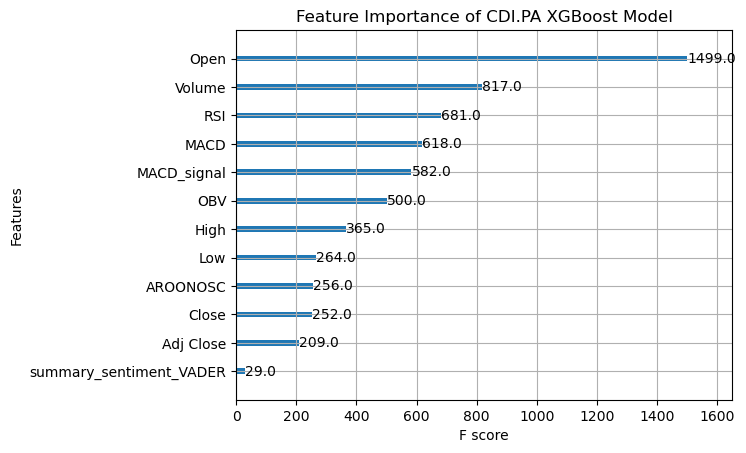

In [ ]:
plot_importance(cdipa_xgboost, title='Feature Importance of CDI.PA XGBoost Model')
plt.show()

### 2.2 CFR.SW

In [ ]:
test_pred, cfrsw_xgboost = walk_foreward_validation(df = df_cfrsw, model = xgboost_forecast)

Performance metrics in the validation set:

-    Regression

MSE: 4.760921160852959
RMSE: 2.1819535194070836
MAE: 1.6709816156404251
R2: -0.11902326994767254

-    Classification

Accuracy: 0.5
Precision: 0.41379310344827586
Recall: 0.09836065573770492
F1 Score: 0.15894039735099336
AUC: 0.4847863884749131

---------------------

Performance metrics in the test set:

MSE: 2.5572928976710645
RMSE: 1.5991538067587696
MAE: 1.2120163437804805
R2: -0.15817101177911397
-    Classification

Accuracy: 0.5465116279069767
Precision: 0.5735294117647058
Recall: 0.7959183673469388
F1 Score: 0.6666666666666666
AUC: 0.5060672917815775


In [ ]:
len(df_cfrsw.loc['2023-01-01':].index)

86

In [ ]:
df_cfrsw.loc['2023-01-01':].index[0]

Timestamp('2023-01-03 00:00:00')

It seems that we don't have data for 2023-01-02 for this stock. We will insert a 0

In [ ]:
test_pred = list(test_pred)

In [ ]:
test_pred.insert(0, 0)
trades_df['CFR.SW'] = test_pred

In [ ]:
#Saving the model
joblib.dump(cfrsw_xgboost, 'models\\xgboost\\cfrsw_xgboost.pkl')

['models\\xgboost\\cfrsw_xgboost.pkl']

In [ ]:
#Loading the model
# cfrsw_xgboost = joblib.load('models\\xgboost\\cfrsw_xgboost.pkl')

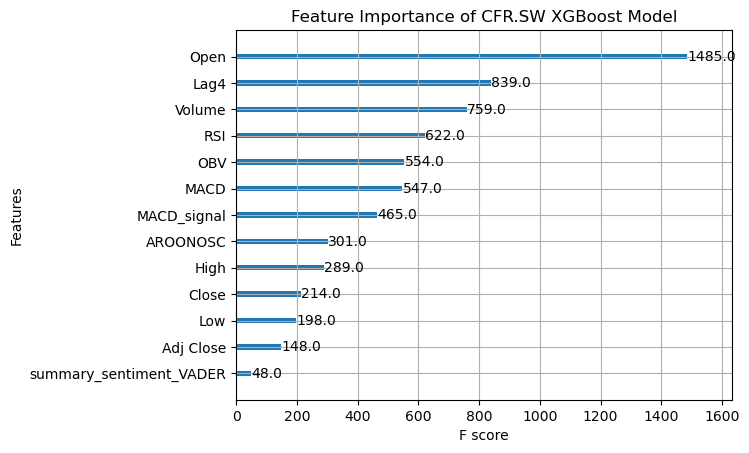

In [ ]:
plot_importance(cfrsw_xgboost, title='Feature Importance of CFR.SW XGBoost Model')
plt.show()

### 2.3 LULU

In [ ]:
test_pred, lulu_xgboost = walk_foreward_validation(df = df_lulu, model = xgboost_forecast)

Performance metrics in the validation set:

-    Regression

MSE: 8.134642737777396
RMSE: 2.852129509292556
MAE: 2.307821591917554
R2: -0.23630491907500661

-    Classification

Accuracy: 0.47410358565737054
Precision: 0.5
Recall: 0.022727272727272728
F1 Score: 0.04347826086956522
AUC: 0.4987585943468296

---------------------

Performance metrics in the test set:

MSE: 2.418853927440358
RMSE: 1.5552665133154375
MAE: 1.2303920755932927
R2: -0.37136019906360596
-    Classification

Accuracy: 0.5
Precision: 0.7647058823529411
Recall: 0.25
F1 Score: 0.37681159420289856
AUC: 0.5661764705882353


In [ ]:
len(df_lulu.loc['2023-01-01':].index)

86

In [ ]:
df_lulu.loc['2023-01-01':].index[0]

Timestamp('2023-01-03 00:00:00')

In [ ]:
test_pred = list(test_pred)

In [ ]:
test_pred.insert(0, 0)
trades_df['LULU'] = test_pred

In [ ]:
#Saving the model
joblib.dump(lulu_xgboost, 'models\\xgboost\\lulu_xgboost.pkl')

['models\\xgboost\\lulu_xgboost.pkl']

In [ ]:
#Loading the model
# lulu_xgboost = joblib.load('models\\xgboost\\lulu_xgboost.pkl')

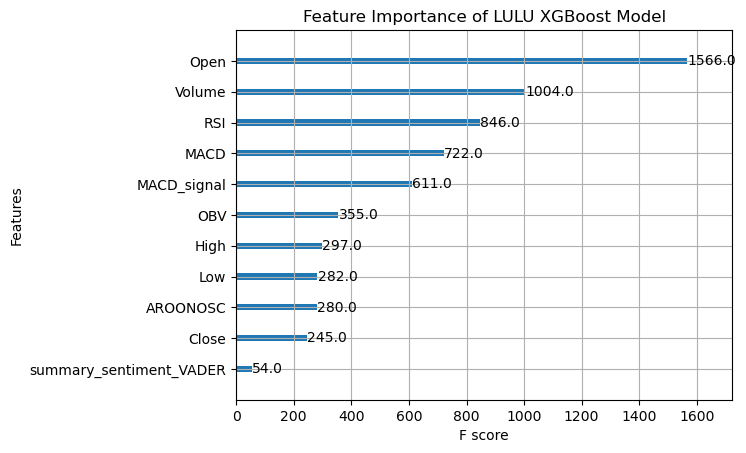

In [ ]:
plot_importance(lulu_xgboost, title='Feature Importance of LULU XGBoost Model')
plt.show()

### 2.4 MCPA

In [ ]:
test_pred, mcpa_xgboost = walk_foreward_validation(df = df_mcpa, model = xgboost_forecast)

Performance metrics in the validation set:

-    Regression

MSE: 3.544555326191708
RMSE: 1.8826989473072184
MAE: 1.483948367799909
R2: -0.07166800286817931

-    Classification

Accuracy: 0.46303501945525294
Precision: 0.4489795918367347
Recall: 0.5365853658536586
F1 Score: 0.4888888888888889
AUC: 0.46605387695668

---------------------

Performance metrics in the test set:

MSE: 2.6839223196074165
RMSE: 1.63826808539
MAE: 1.2755387493679242
R2: -0.5569694949738291
-    Classification

Accuracy: 0.4942528735632184
Precision: 0.547945205479452
Recall: 0.7843137254901961
F1 Score: 0.6451612903225806
AUC: 0.4338235294117647


In [ ]:
len(df_mcpa.loc['2023-01-01':].index)

87

In [ ]:
trades_df['MC.PA'] = test_pred

In [ ]:
#Saving the model
joblib.dump(mcpa_xgboost, 'models\\xgboost\\mcpa_xgboost.pkl')

['models\\xgboost\\mcpa_xgboost.pkl']

In [ ]:
#Loading the model
# mcpa_xgboost = joblib.load('models\\xgboost\\mcpa_xgboost.pkl')

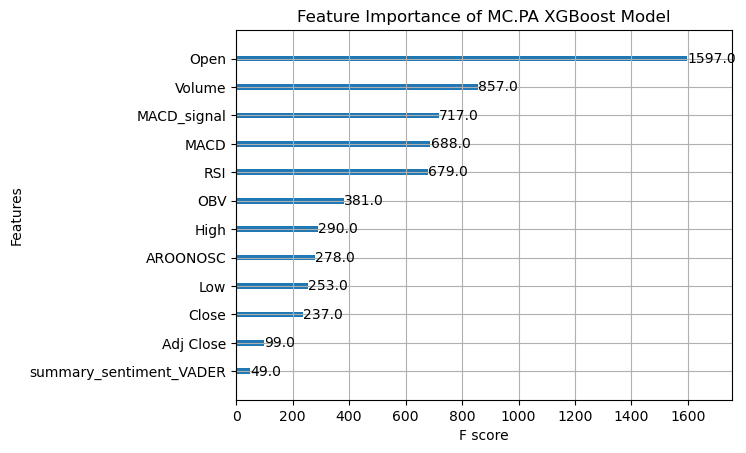

In [ ]:
plot_importance(mcpa_xgboost, title='Feature Importance of MC.PA XGBoost Model')
plt.show()

### 2.5 MONC.MI

In [ ]:
test_pred, moncmi_xgboost = walk_foreward_validation(df = df_moncmi, model = xgboost_forecast)

Performance metrics in the validation set:

-    Regression

MSE: 5.709864947809112
RMSE: 2.3895323701111715
MAE: 1.8182354398011293
R2: -0.05558853092493554

-    Classification

Accuracy: 0.55078125
Precision: 0.4782608695652174
Recall: 0.09649122807017543
F1 Score: 0.16058394160583941
AUC: 0.5059920929083271

---------------------

Performance metrics in the test set:

MSE: 3.1573397803756396
RMSE: 1.7768904806925045
MAE: 1.4759540622421956
R2: -0.6170884767836302
-    Classification

Accuracy: 0.42528735632183906
Precision: 0.3333333333333333
Recall: 0.041666666666666664
F1 Score: 0.07407407407407407
AUC: 0.4695512820512821


In [ ]:
len(df_moncmi.loc['2023-01-01':].index)

87

In [ ]:
trades_df['MONC.MI'] = test_pred

In [ ]:
#Saving the model
joblib.dump(moncmi_xgboost, 'models\\xgboost\\moncmi_xgboost.pkl')

['models\\xgboost\\moncmi_xgboost.pkl']

In [ ]:
#Loading the model
# moncmi_xgboost = joblib.load('models\\xgboost\\moncmi_xgboost.pkl')

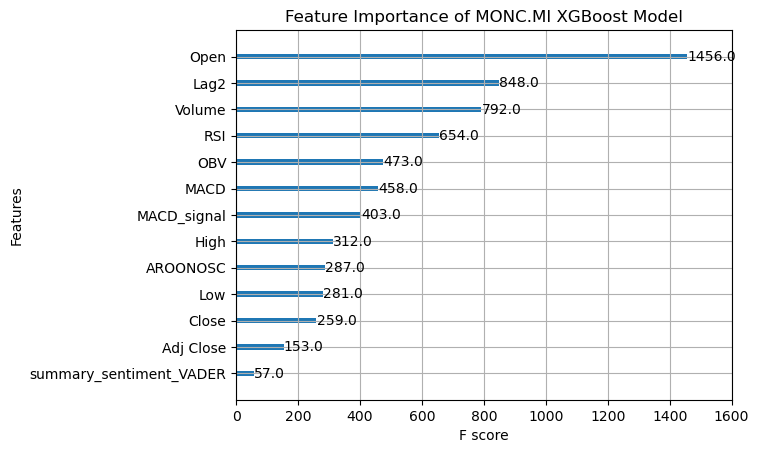

In [ ]:
plot_importance(moncmi_xgboost, title='Feature Importance of MONC.MI XGBoost Model')
plt.show()

### 2.6 PNDORA.CO

In [ ]:
test_pred, pndoraco_xgboost = walk_foreward_validation(df = df_pndoraco, model = xgboost_forecast)

Performance metrics in the validation set:

-    Regression

MSE: 6.78950709243214
RMSE: 2.605668262160811
MAE: 2.018776231970279
R2: -0.07315160737624593

-    Classification

Accuracy: 0.5158730158730159
Precision: 0.47058823529411764
Recall: 0.20168067226890757
F1 Score: 0.2823529411764706
AUC: 0.49933657673595755

---------------------

Performance metrics in the test set:

MSE: 12.666134307084635
RMSE: 3.5589512931599154
MAE: 2.9204186254799813
R2: -1.7992591328463132
-    Classification

Accuracy: 0.5813953488372093
Precision: 0.5882352941176471
Recall: 0.9803921568627451
F1 Score: 0.7352941176470589
AUC: 0.49019607843137253


In [ ]:
len(df_pndoraco.loc['2023-01-01':].index)

86

In [ ]:
df_pndoraco.loc['2023-01-01':].index[-1]

Timestamp('2023-05-04 00:00:00')

This stock seems to not have the last trading day, so we will append a 0.

In [ ]:
test_pred = list(test_pred)

In [ ]:
test_pred.append(0)
trades_df['PNDORA.CO'] = test_pred

In [ ]:
#Saving the model
joblib.dump(pndoraco_xgboost, 'models\\xgboost\\pndoraco_xgboost.pkl')

['models\\xgboost\\pndoraco_xgboost.pkl']

In [ ]:
#Loading the model
# pndoraco_xgboost = joblib.load('models\\xgboost\\pndoraco_xgboost.pkl')

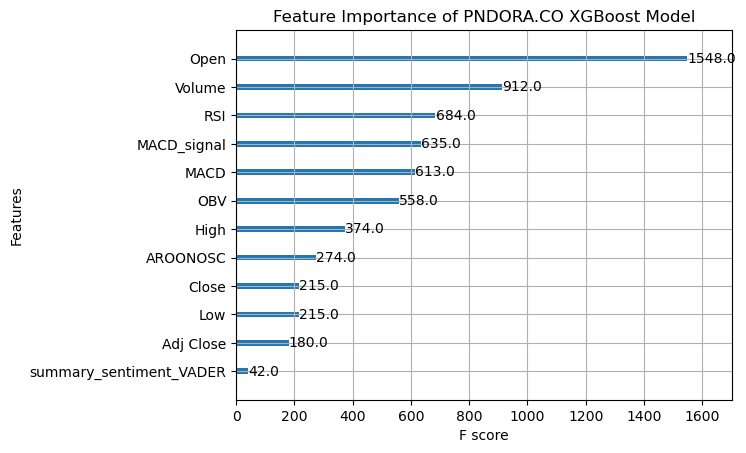

In [ ]:
plot_importance(pndoraco_xgboost, title='Feature Importance of PNDORA.CO XGBoost Model')
plt.show()

### 2.7 RL

In [ ]:
test_pred, rl_xgboost = walk_foreward_validation(df = df_rl, model = xgboost_forecast)

Performance metrics in the validation set:

-    Regression

MSE: 6.449469079497461
RMSE: 2.539580492817162
MAE: 1.9970469188516544
R2: -0.1807520025128566

-    Classification

Accuracy: 0.4900398406374502
Precision: 0.48878923766816146
Recall: 0.8861788617886179
F1 Score: 0.630057803468208
AUC: 0.49777693089430897

---------------------

Performance metrics in the test set:

MSE: 2.9252039321665646
RMSE: 1.7103227567235855
MAE: 1.3368029450941792
R2: -0.1620078230131754
-    Classification

Accuracy: 0.5232558139534884
Precision: 0.5862068965517241
Recall: 0.3695652173913043
F1 Score: 0.4533333333333333
AUC: 0.5347826086956521


In [ ]:
len(df_rl.loc['2023-01-01':].index)

86

In [ ]:
df_rl.loc['2023-01-01':].index[0]

Timestamp('2023-01-03 00:00:00')

In [ ]:
test_pred = list(test_pred)

In [ ]:
test_pred.insert(0, 0)
trades_df['RL'] = test_pred

In [ ]:
#Saving the model
joblib.dump(rl_xgboost, 'models\\xgboost\\rl_xgboost.pkl')

['models\\xgboost\\rl_xgboost.pkl']

In [ ]:
#Loading the model
# rl_xgboost = joblib.load('models\\xgboost\\rl_xgboost.pkl')

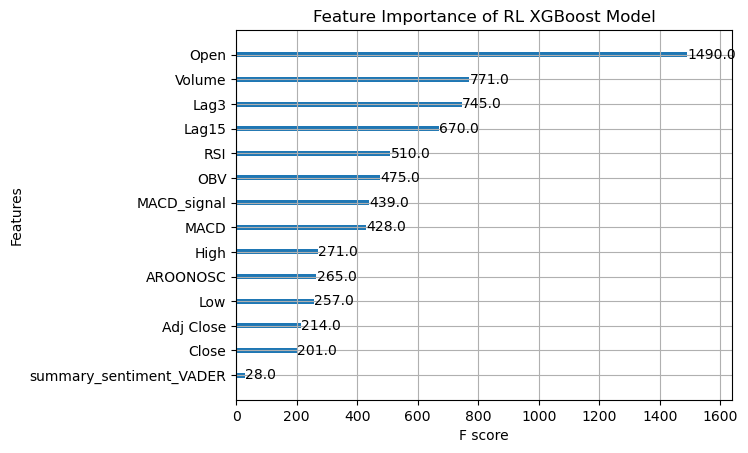

In [ ]:
plot_importance(rl_xgboost, title='Feature Importance of RL XGBoost Model')
plt.show()

### 2.8 RMS.PA

In [ ]:
test_pred, rmspa_xgboost = walk_foreward_validation(df = df_rmspa, model = xgboost_forecast)

Performance metrics in the validation set:

-    Regression

MSE: 4.153825556482348
RMSE: 2.038093608370908
MAE: 1.6240165275386635
R2: -0.06728146742120678

-    Classification

Accuracy: 0.49416342412451364
Precision: 0.47674418604651164
Recall: 0.6721311475409836
F1 Score: 0.5578231292517006
AUC: 0.5027322404371585

---------------------

Performance metrics in the test set:

MSE: 2.193176624898213
RMSE: 1.4809377518647477
MAE: 1.2129339212506172
R2: -0.14819254298727724
-    Classification

Accuracy: 0.4942528735632184
Precision: 0.6363636363636364
Recall: 0.39622641509433965
F1 Score: 0.48837209302325585
AUC: 0.5216426193118757


In [ ]:
len(df_rmspa.loc['2023-01-01':].index)

87

In [ ]:
trades_df['RMS.PA'] = test_pred

In [ ]:
#Saving the model
joblib.dump(rmspa_xgboost, 'models\\xgboost\\rmspa_xgboost.pkl')

['models\\xgboost\\rmspa_xgboost.pkl']

In [ ]:
#Loading the model
# rmspa_xgboost = joblib.load('models\\xgboost\\rmspa_xgboost.pkl')

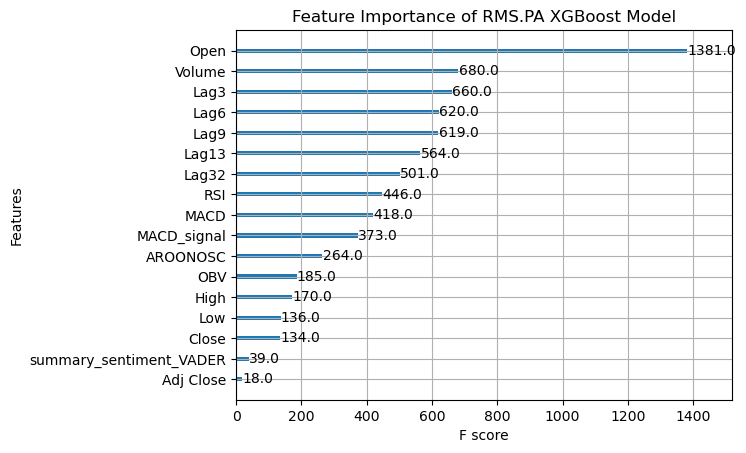

In [ ]:
plot_importance(rmspa_xgboost, title='Feature Importance of RMS.PA XGBoost Model')
plt.show()

### 2.9 UHR.SW

In [ ]:
test_pred, uhrsw_xgboost = walk_foreward_validation(df = df_uhrsw, model = xgboost_forecast)

Performance metrics in the validation set:

-    Regression

MSE: 4.1356827725686705
RMSE: 2.0336378174514436
MAE: 1.5237090273794693
R2: -0.05905699736982428

-    Classification

Accuracy: 0.5039370078740157
Precision: 0.5483870967741935
Recall: 0.13178294573643412
F1 Score: 0.2125
AUC: 0.5098914728682171

---------------------

Performance metrics in the test set:

MSE: 4.991806643349532
RMSE: 2.2342351360923343
MAE: 1.808164961088947
R2: -0.9978668683957079
-    Classification

Accuracy: 0.5581395348837209
Precision: 0.5581395348837209
Recall: 1.0
F1 Score: 0.7164179104477612
AUC: 0.5


In [ ]:
len(df_uhrsw.loc['2023-01-01':].index)

86

In [ ]:
df_uhrsw.loc['2023-01-01':].index[0]

Timestamp('2023-01-03 00:00:00')

In [ ]:
test_pred = list(test_pred)

In [ ]:
test_pred.insert(0, 0)
trades_df['UHR.SW'] = test_pred

In [ ]:
#Saving the model
joblib.dump(uhrsw_xgboost, 'models\\xgboost\\uhrsw_xgboost.pkl')

['models\\xgboost\\uhrsw_xgboost.pkl']

In [ ]:
#Loading the model
# uhrsw_xgboost = joblib.load('models\\xgboost\\uhrsw_xgboost.pkl')

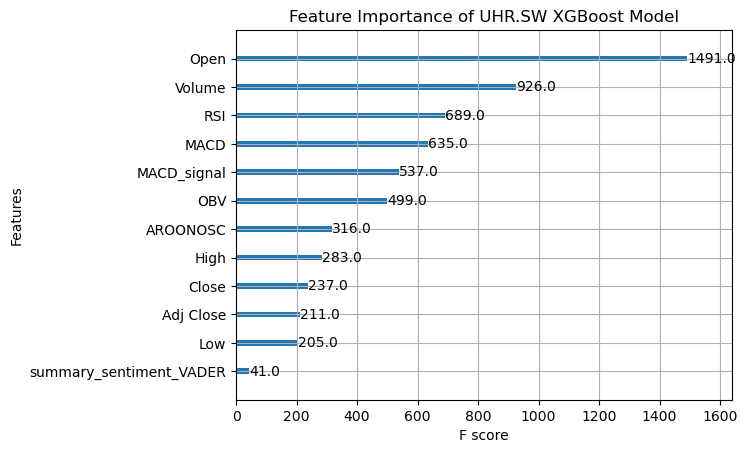

In [ ]:
plot_importance(uhrsw_xgboost, title='Feature Importance of UHR.SW XGBoost Model')
plt.show()

### 2.10 VFC

In [ ]:
test_pred, vfc_xgboost = walk_foreward_validation(df = df_vfc, model = xgboost_forecast)

Performance metrics in the validation set:

-    Regression

MSE: 5.512051994895344
RMSE: 2.3477759677821357
MAE: 1.7939157166194515
R2: -0.07340650040017427

-    Classification

Accuracy: 0.450199203187251
Precision: 0.41899441340782123
Recall: 0.6880733944954128
F1 Score: 0.5208333333333333
AUC: 0.47783951414911485

---------------------

Performance metrics in the test set:

MSE: 6.944897734286713
RMSE: 2.635317387770724
MAE: 2.047348129703208
R2: -0.05185131522525266
-    Classification

Accuracy: 0.5348837209302325
Precision: 0.6071428571428571
Recall: 0.3695652173913043
F1 Score: 0.45945945945945943
AUC: 0.5472826086956522


In [ ]:
len(df_vfc.loc['2023-01-01':].index)

86

In [ ]:
df_vfc.loc['2023-01-01':].index[0]

Timestamp('2023-01-03 00:00:00')

In [ ]:
test_pred = list(test_pred)

In [ ]:
test_pred.insert(0, 0)
trades_df['VFC'] = test_pred

In [ ]:
#Saving the model
joblib.dump(vfc_xgboost, 'models\\xgboost\\vfc_xgboost.pkl')

['models\\xgboost\\vfc_xgboost.pkl']

In [ ]:
#Loading the model
# vfc_xgboost = joblib.load('models\\xgboost\\vfc_xgboost.pkl')

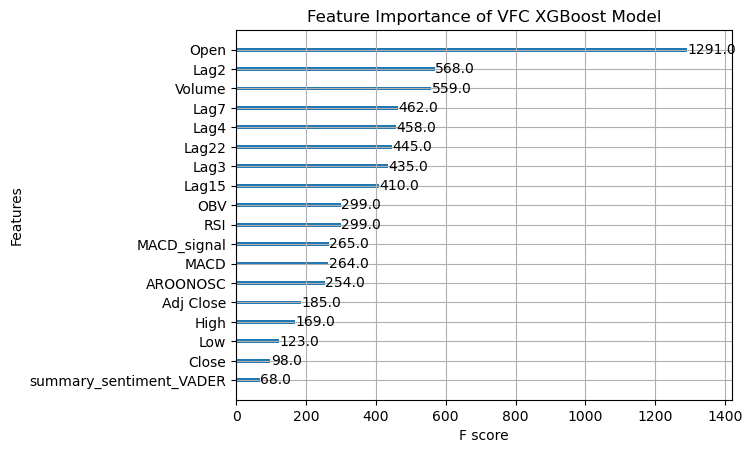

In [ ]:
plot_importance(vfc_xgboost, title='Feature Importance of VFC XGBoost Model')
plt.show()

Setting the Date of trades_df as index

In [ ]:
trades_df = trades_df.set_index('Date')

## 3. LSTM

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
def evaluate_lstm(model, X_train, X_validation, X_test, y_train, y_validation, y_test):
  pred_train = model.predict(X_train)
  pred_validation = model.predict(X_validation)
  pred_test = model.predict(X_test)

  #Training set
    #Regression
  mae = mean_absolute_error(y_train, pred_train)
  mse = mean_squared_error(y_train, pred_train)
  rmse = mean_squared_error(y_train, pred_train, squared=False)
  r2 = r2_score(y_train, pred_train)
    #Classification
  real_class = y_train
  real_class[real_class>0] = 1            #Encoding positive values as 1
  real_class[real_class<=0] = 0           # and negative values as 0
  predicted_class = np.array(pred_train.copy())
  predicted_class[predicted_class>0] = 1
  predicted_class[predicted_class<=0] = 0
  acc = accuracy_score(real_class, predicted_class)
  precision = precision_score(real_class, predicted_class)
  recall = recall_score(real_class, predicted_class)
  f1 = f1_score(real_class, predicted_class)
  auc = roc_auc_score(real_class, predicted_class)
  print('Performance metrics in the train set:\n')
  print('-    Regression\n')
  print(f'MSE: {mse}')
  print(f'RMSE: {rmse}')
  print(f'MAE: {mae}')
  print(f'R2: {r2}\n')
  print('-    Classification\n')
  print(f'Accuracy: {acc}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1 Score: {f1}')
  print(f'AUC: {auc}')
  print('\n---------------------\n')

  #Validation set
    #Regression
  mae = mean_absolute_error(y_validation, pred_validation)
  mse = mean_squared_error(y_validation, pred_validation)
  rmse = mean_squared_error(y_validation, pred_validation, squared=False)
  r2 = r2_score(y_validation, pred_validation)
    #Classification
  real_class = y_validation
  real_class[real_class>0] = 1            #Encoding positive values as 1
  real_class[real_class<=0] = 0           # and negative values as 0
  predicted_class = np.array(pred_validation.copy())
  predicted_class[predicted_class>0] = 1
  predicted_class[predicted_class<=0] = 0
  acc = accuracy_score(real_class, predicted_class)
  precision = precision_score(real_class, predicted_class)
  recall = recall_score(real_class, predicted_class)
  f1 = f1_score(real_class, predicted_class)
  auc = roc_auc_score(real_class, predicted_class)
  print('Performance metrics in the validation set:\n')
  print('-    Regression\n')
  print(f'MSE: {mse}')
  print(f'RMSE: {rmse}')
  print(f'MAE: {mae}')
  print(f'R2: {r2}\n')
  print('-    Classification\n')
  print(f'Accuracy: {acc}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1 Score: {f1}')
  print(f'AUC: {auc}')
  print('\n---------------------\n')

  #Validation set
    #Regression
  mae = mean_absolute_error(y_test, pred_test)
  mse = mean_squared_error(y_test, pred_test)
  rmse = mean_squared_error(y_test, pred_test, squared=False)
  r2 = r2_score(y_test, pred_test)
    #Classification
  real_class = y_test
  real_class[real_class>0] = 1            #Encoding positive values as 1
  real_class[real_class<=0] = 0           # and negative values as 0
  predicted_class = np.array(pred_test.copy())
  predicted_class[predicted_class>0] = 1
  predicted_class[predicted_class<=0] = 0
  acc = accuracy_score(real_class, predicted_class)
  precision = precision_score(real_class, predicted_class)
  recall = recall_score(real_class, predicted_class)
  f1 = f1_score(real_class, predicted_class)
  auc = roc_auc_score(real_class, predicted_class)
  print('Performance metrics in the test set:\n')
  print('-    Regression\n')
  print(f'MSE: {mse}')
  print(f'RMSE: {rmse}')
  print(f'MAE: {mae}')
  print(f'R2: {r2}\n')
  print('-    Classification\n')
  print(f'Accuracy: {acc}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1 Score: {f1}')
  print(f'AUC: {auc}')
  print('\n---------------------\n')

  return predicted_class

In [10]:
trading_dates = list(df_cdipa.loc['2023-01-01':].index.astype(str))
trades_df_lstm = pd.DataFrame()
trades_df_lstm['Date'] = trading_dates

### 3.1 CDI.PA

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [12]:
df_train, df_validation, df_test = train_validation_test(df_cdipa)

In [13]:
X_train = df_train.drop(columns=['Returns']).values
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_train = df_train['Returns'].values

X_validation = df_validation.drop(columns=['Returns']).values
X_validation = scaler.transform(X_validation)
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
y_validation = df_validation['Returns'].values

X_test = df_test.drop(columns=['Returns']).values
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_test = df_test['Returns'].values

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((992, 1, 12), (992,), (257, 1, 12), (257,), (87, 1, 12), (87,))

In [14]:
cdipa_lstm = Sequential()
cdipa_lstm.add(LSTM(units = 64, activation = 'tanh', kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0),
                    input_shape = [1,12], unroll = True, stateful = False))
    
cdipa_lstm.add(Dense(units=32, kernel_initializer=glorot_uniform(seed=0), bias_initializer=glorot_uniform(seed=0),
                    activation='relu'))

cdipa_lstm.add(Dense(units = 1, kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0)))
    
cdipa_lstm.compile(loss = "mse", optimizer = "adam")

In [15]:
cdipa_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19712     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,825
Trainable params: 21,825
Non-trainable params: 0
_________________________________________________________________


In [16]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

In [17]:
cdipa_lstm.fit(X_train, y_train, epochs=100, 
                  batch_size=32, callbacks=[es], shuffle=False)

Epoch 1/100
31/31 [==============================] - 6s 3ms/step - loss: 2.6241
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 2.4106
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 2.3717
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 2.3606
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 2.3538
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 2.3484
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 2.3445
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 2.3401
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 2.3367
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 2.3321
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 2.3291
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 2.3253
Epoch 13/100
31/31 [=================

In [ ]:
#Saving the model
cdipa_lstm.save('models/lstm/cdipa_lstm.h5')

In [ ]:
#Load the model
from keras.models import load_model
cdipa_lstm = load_model('models/lstm/cdipa_lstm.h5')

In [18]:
test_pred = evaluate_lstm(cdipa_lstm, X_train, X_validation, X_test, y_train, y_validation, y_test)

3/3 [==============================] - 0s 5ms/step
Performance metrics in the train set:

-    Regression

MSE: 1.936582170315245
RMSE: 1.3916113574972162
MAE: 1.0300917180926807
R2: 0.18553599404693022

-    Classification

Accuracy: 0.592741935483871
Precision: 0.5976331360946746
Recall: 0.753731343283582
F1 Score: 0.6666666666666667
AUC: 0.5786200576067033

---------------------

Performance metrics in the validation set:

-    Regression

MSE: 3.4329765467957705
RMSE: 1.8528293355826841
MAE: 1.4176699407111162
R2: 0.03973872756808938

-    Classification

Accuracy: 0.5836575875486382
Precision: 0.5692307692307692
Recall: 0.8283582089552238
F1 Score: 0.6747720364741642
AUC: 0.5727156898434655

---------------------

Performance metrics in the test set:

-    Regression

MSE: 2.123376136764777
RMSE: 1.4571808867689615
MAE: 1.1195241275879009
R2: -0.010020936577017636

-    Classification

Accuracy: 0.47126436781609193
Precision: 0.6363636363636364
Recall: 0.14285714285714285
F1 Score

In [19]:
len(df_cdipa.loc['2023-01-01':].index)

87

In [20]:
trades_df_lstm['CDI.PA'] = test_pred 

### 3.2 CFR.SW

In [21]:
df_train, df_validation, df_test = train_validation_test(df_cfrsw)

In [22]:
X_train = df_train.drop(columns=['Returns']).values
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_train = df_train['Returns'].values

X_validation = df_validation.drop(columns=['Returns']).values
X_validation = scaler.transform(X_validation)
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
y_validation = df_validation['Returns'].values

X_test = df_test.drop(columns=['Returns']).values
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_test = df_test['Returns'].values

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((966, 1, 13), (966,), (254, 1, 13), (254,), (86, 1, 13), (86,))

In [23]:
cfrsw_lstm = Sequential()
cfrsw_lstm.add(LSTM(units = 64, activation = 'tanh', kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0),
                    input_shape = [1,13], unroll = True, stateful = False))
    
cfrsw_lstm.add(Dense(units=32, kernel_initializer=glorot_uniform(seed=0), bias_initializer=glorot_uniform(seed=0),
                    activation='relu'))

cfrsw_lstm.add(Dense(units = 1, kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0)))
    
cfrsw_lstm.compile(loss = "mse", optimizer = "adam")

In [24]:
cfrsw_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                19968     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 22,081
Trainable params: 22,081
Non-trainable params: 0
_________________________________________________________________


In [25]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

In [26]:
cfrsw_lstm.fit(X_train, y_train, epochs=100, 
                  batch_size=32, callbacks=[es], shuffle=False)

Epoch 1/100
31/31 [==============================] - 2s 3ms/step - loss: 2.1753
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 1.9989
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 1.9657
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 1.9557
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 1.9481
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 1.9412
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 1.9346
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 1.9273
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 1.9205
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 1.9127
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 1.9056
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 1.8986
Epoch 13/100
31/31 [=================

In [ ]:
#Saving the model
cfrsw_lstm.save('models/lstm/cfrsw_lstm.h5')

In [ ]:
#Load the model
from keras.models import load_model
cfrsw_lstm = load_model('models/lstm/cfrsw_lstm.h5')

In [27]:
test_pred = evaluate_lstm(cfrsw_lstm, X_train, X_validation, X_test, y_train, y_validation, y_test)

3/3 [==============================] - 0s 3ms/step
Performance metrics in the train set:

-    Regression

MSE: 1.4831218307546319
RMSE: 1.2178348947023285
MAE: 0.9309676954482289
R2: 0.24976733398006

-    Classification

Accuracy: 0.6159420289855072
Precision: 0.6184738955823293
Recall: 0.6298568507157464
F1 Score: 0.624113475177305
AUC: 0.6157669997813533

---------------------

Performance metrics in the validation set:

-    Regression

MSE: 4.496090119645946
RMSE: 2.1203985756564605
MAE: 1.6178340976890861
R2: -0.05677647196414437

-    Classification

Accuracy: 0.5393700787401575
Precision: 0.5206611570247934
Recall: 0.5163934426229508
F1 Score: 0.5185185185185185
AUC: 0.5384997516145057

---------------------

Performance metrics in the test set:

-    Regression

MSE: 3.928238391157809
RMSE: 1.9819784033025711
MAE: 1.5966404050453173
R2: -0.7790577826028879

-    Classification

Accuracy: 0.47674418604651164
Precision: 0.625
Recall: 0.20408163265306123
F1 Score: 0.307692307692

In [28]:
len(df_cfrsw.loc['2023-01-01':].index)

86

In [29]:
df_cfrsw.loc['2023-01-01':].index[0]

Timestamp('2023-01-03 00:00:00')

In [30]:
test_pred = list(test_pred)
test_pred.insert(0, 0)
trades_df_lstm['CFR.SW'] = test_pred

### 3.3 LULU

In [31]:
df_train, df_validation, df_test = train_validation_test(df_lulu)

In [32]:
X_train = df_train.drop(columns=['Returns']).values
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_train = df_train['Returns'].values

X_validation = df_validation.drop(columns=['Returns']).values
X_validation = scaler.transform(X_validation)
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
y_validation = df_validation['Returns'].values

X_test = df_test.drop(columns=['Returns']).values
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_test = df_test['Returns'].values

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((974, 1, 12), (974,), (251, 1, 12), (251,), (86, 1, 12), (86,))

In [33]:
lulu_lstm = Sequential()
lulu_lstm.add(LSTM(units = 64, activation = 'tanh', kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0),
                    input_shape = [1,12], unroll = True, stateful = False))
    
lulu_lstm.add(Dense(units=32, kernel_initializer=glorot_uniform(seed=0), bias_initializer=glorot_uniform(seed=0),
                    activation='relu'))

lulu_lstm.add(Dense(units = 1, kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0)))
    
lulu_lstm.compile(loss = "mse", optimizer = "adam")

In [34]:
lulu_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                19712     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,825
Trainable params: 21,825
Non-trainable params: 0
_________________________________________________________________


In [35]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

In [36]:
lulu_lstm.fit(X_train, y_train, epochs=100, 
                  batch_size=32, callbacks=[es], shuffle=False)

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 3.9910
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 3.7925
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 3.7579
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 3.7475
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 3.7380
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 3.7291
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 3.7206
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 3.7123
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 3.7043
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 3.6958
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 3.6887
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 3.6818
Epoch 13/100
31/31 [=================

In [ ]:
#Saving the model
lulu_lstm.save('models/lstm/lulu_lstm.h5')

In [ ]:
#Load the model
from keras.models import load_model
lulu_lstm = load_model('models/lstm/lulu_lstm.h5')

In [37]:
test_pred = evaluate_lstm(lulu_lstm, X_train, X_validation, X_test, y_train, y_validation, y_test)

3/3 [==============================] - 0s 3ms/step
Performance metrics in the train set:

-    Regression

MSE: 3.2495102287311655
RMSE: 1.8026397945044832
MAE: 1.325288972742074
R2: 0.13891060035703762

-    Classification

Accuracy: 0.5965092402464066
Precision: 0.621900826446281
Recall: 0.589041095890411
F1 Score: 0.6050251256281407
AUC: 0.5968963578804107

---------------------

Performance metrics in the validation set:

-    Regression

MSE: 7.86415880764736
RMSE: 2.8043107544720076
MAE: 2.15838261779115
R2: -0.19519670767224362

-    Classification

Accuracy: 0.5099601593625498
Precision: 0.5257142857142857
Recall: 0.696969696969697
F1 Score: 0.5993485342019544
AUC: 0.4997453526865292

---------------------

Performance metrics in the test set:

-    Regression

MSE: 2.5538447932456845
RMSE: 1.59807534029084
MAE: 1.2890759153820255
R2: -0.44789276620314267

-    Classification

Accuracy: 0.5
Precision: 0.6
Recall: 0.5192307692307693
F1 Score: 0.5567010309278351
AUC: 0.4949095022

In [38]:
len(df_lulu.loc['2023-01-01':].index)

86

In [39]:
df_lulu.loc['2023-01-01':].index[0]

Timestamp('2023-01-03 00:00:00')

In [40]:
test_pred = list(test_pred)
test_pred.insert(0, 0)
trades_df_lstm['LULU'] = test_pred

### 3.4 MC.PA

In [41]:
df_train, df_validation, df_test = train_validation_test(df_mcpa)

In [42]:
X_train = df_train.drop(columns=['Returns']).values
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_train = df_train['Returns'].values

X_validation = df_validation.drop(columns=['Returns']).values
X_validation = scaler.transform(X_validation)
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
y_validation = df_validation['Returns'].values

X_test = df_test.drop(columns=['Returns']).values
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_test = df_test['Returns'].values

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((992, 1, 12), (992,), (257, 1, 12), (257,), (87, 1, 12), (87,))

In [43]:
mcpa_lstm = Sequential()
mcpa_lstm.add(LSTM(units = 64, activation = 'tanh', kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0),
                    input_shape = [1,12], unroll = True, stateful = False))
    
mcpa_lstm.add(Dense(units=32, kernel_initializer=glorot_uniform(seed=0), bias_initializer=glorot_uniform(seed=0),
                    activation='relu'))

mcpa_lstm.add(Dense(units = 1, kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0)))
    
mcpa_lstm.compile(loss = "mse", optimizer = "adam")

In [44]:
mcpa_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                19712     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,825
Trainable params: 21,825
Non-trainable params: 0
_________________________________________________________________


In [45]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

In [46]:
mcpa_lstm.fit(X_train, y_train, epochs=100, 
                  batch_size=32, callbacks=[es], shuffle=False)

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 2.0574
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 1.8537
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 1.8339
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 1.8296
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 1.8261
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 1.8233
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 1.8211
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 1.8192
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 1.8173
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 1.8156
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 1.8139
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 1.8123
Epoch 13/100
31/31 [=================

In [ ]:
#Saving the model
mcpa_lstm.save('models/lstm/mcpa_lstm.h5')

In [ ]:
#Load the model
from keras.models import load_model
mcpa_lstm = load_model('models/lstm/mcpa_lstm.h5')

In [47]:
test_pred = evaluate_lstm(mcpa_lstm, X_train, X_validation, X_test, y_train, y_validation, y_test)

3/3 [==============================] - 0s 3ms/step
Performance metrics in the train set:

-    Regression

MSE: 1.6438124957094695
RMSE: 1.28211251289014
MAE: 0.9654435932704524
R2: 0.10094174051716309

-    Classification

Accuracy: 0.592741935483871
Precision: 0.5904173106646059
Recall: 0.7332053742802304
F1 Score: 0.6541095890410958
AUC: 0.5852863389447861

---------------------

Performance metrics in the validation set:

-    Regression

MSE: 3.5021381052533003
RMSE: 1.8714000388087257
MAE: 1.450212026212069
R2: -0.05884349477984818

-    Classification

Accuracy: 0.5058365758754864
Precision: 0.48412698412698413
Recall: 0.4959349593495935
F1 Score: 0.4899598393574297
AUC: 0.5054301662419609

---------------------

Performance metrics in the test set:

-    Regression

MSE: 2.1436451129923237
RMSE: 1.4641192277244104
MAE: 1.1715532505941577
R2: -0.24354942190240902

-    Classification

Accuracy: 0.47126436781609193
Precision: 0.8571428571428571
Recall: 0.11764705882352941
F1 Scor

In [48]:
len(df_mcpa.loc['2023-01-01':].index)

87

In [49]:
trades_df_lstm['MC.PA'] = test_pred

### 3.5 MONC.MI

In [50]:
df_train, df_validation, df_test = train_validation_test(df_moncmi)

In [51]:
X_train = df_train.drop(columns=['Returns']).values
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_train = df_train['Returns'].values

X_validation = df_validation.drop(columns=['Returns']).values
X_validation = scaler.transform(X_validation)
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
y_validation = df_validation['Returns'].values

X_test = df_test.drop(columns=['Returns']).values
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_test = df_test['Returns'].values

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((979, 1, 13), (979,), (256, 1, 13), (256,), (87, 1, 13), (87,))

In [52]:
moncmi_lstm = Sequential()
moncmi_lstm.add(LSTM(units = 64, activation = 'tanh', kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0),
                    input_shape = [1,13], unroll = True, stateful = False))
    
moncmi_lstm.add(Dense(units=32, kernel_initializer=glorot_uniform(seed=0), bias_initializer=glorot_uniform(seed=0),
                    activation='relu'))

moncmi_lstm.add(Dense(units = 1, kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0)))
    
moncmi_lstm.compile(loss = "mse", optimizer = "adam")

In [53]:
moncmi_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                19968     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 22,081
Trainable params: 22,081
Non-trainable params: 0
_________________________________________________________________


In [54]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

In [55]:
moncmi_lstm.fit(X_train, y_train, epochs=100, 
                  batch_size=32, callbacks=[es], shuffle=False)

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 3.6936
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 3.4828
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 3.4324
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 3.4196
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 3.4113
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 3.4028
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 3.3961
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 3.3887
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 3.3818
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 3.3747
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 3.3684
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss: 3.3606
Epoch 13/100
31/31 [=================

In [ ]:
#Saving the model
moncmi_lstm.save('models/lstm/moncmi_lstm.h5')

In [ ]:
#Load the model
from keras.models import load_model
moncmi_lstm = load_model('models/lstm/moncmi_lstm.h5')

In [56]:
test_pred = evaluate_lstm(moncmi_lstm, X_train, X_validation, X_test, y_train, y_validation, y_test)

3/3 [==============================] - 0s 5ms/step
Performance metrics in the train set:

-    Regression

MSE: 2.6236596729581114
RMSE: 1.619771487882816
MAE: 1.2192555825488591
R2: 0.2425371734837799

-    Classification

Accuracy: 0.6537282941777324
Precision: 0.6443202979515829
Recall: 0.7004048582995951
F1 Score: 0.6711930164888457
AUC: 0.6532952126549523

---------------------

Performance metrics in the validation set:

-    Regression

MSE: 5.598701706903946
RMSE: 2.3661575828553656
MAE: 1.8112083550851894
R2: -0.035037669699231166

-    Classification

Accuracy: 0.5
Precision: 0.4527027027027027
Recall: 0.5877192982456141
F1 Score: 0.5114503816793894
AUC: 0.5086483815171732

---------------------

Performance metrics in the test set:

-    Regression

MSE: 2.0279408161321326
RMSE: 1.424057869657035
MAE: 1.1269875332803114
R2: -0.03864644082630386

-    Classification

Accuracy: 0.5287356321839081
Precision: 0.5660377358490566
Recall: 0.625
F1 Score: 0.594059405940594
AUC: 0.51

In [57]:
len(df_moncmi.loc['2023-01-01':].index)

87

In [58]:
trades_df_lstm['MONC.MI'] = test_pred

### 3.6 PNDORA.CO

In [59]:
df_train, df_validation, df_test = train_validation_test(df_pndoraco)

In [60]:
X_train = df_train.drop(columns=['Returns']).values
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_train = df_train['Returns'].values

X_validation = df_validation.drop(columns=['Returns']).values
X_validation = scaler.transform(X_validation)
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
y_validation = df_validation['Returns'].values

X_test = df_test.drop(columns=['Returns']).values
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_test = df_test['Returns'].values

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((963, 1, 12), (963,), (252, 1, 12), (252,), (86, 1, 12), (86,))

In [61]:
pndoraco_lstm = Sequential()
pndoraco_lstm.add(LSTM(units = 64, activation = 'tanh', kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0),
                    input_shape = [1,12], unroll = True, stateful = False))
    
pndoraco_lstm.add(Dense(units=32, kernel_initializer=glorot_uniform(seed=0), bias_initializer=glorot_uniform(seed=0),
                    activation='relu'))

pndoraco_lstm.add(Dense(units = 1, kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0)))
    
pndoraco_lstm.compile(loss = "mse", optimizer = "adam")

In [62]:
pndoraco_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                19712     
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 21,825
Trainable params: 21,825
Non-trainable params: 0
_________________________________________________________________


In [63]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

In [64]:
pndoraco_lstm.fit(X_train, y_train, epochs=100, 
                  batch_size=32, callbacks=[es], shuffle=False)

Epoch 1/100
31/31 [==============================] - 2s 3ms/step - loss: 6.1702
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 5.9123
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 5.8285
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 5.8086
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 5.7985
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 5.7890
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 5.7803
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 5.7726
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 5.7659
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 5.7592
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 5.7526
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 5.7460
Epoch 13/100
31/31 [=================

In [ ]:
#Saving the model
pndoraco_lstm.save('models/lstm/pndoraco_lstm.h5')

In [ ]:
#Load the model
from keras.models import load_model
pndoraco_lstm = load_model('models/lstm/pndoraco_lstm.h5')

In [65]:
test_pred = evaluate_lstm(pndoraco_lstm, X_train, X_validation, X_test, y_train, y_validation, y_test)

3/3 [==============================] - 0s 3ms/step
Performance metrics in the train set:

-    Regression

MSE: 4.949229900384151
RMSE: 2.2246864723785578
MAE: 1.6236801979922841
R2: 0.15164258950688703

-    Classification

Accuracy: 0.5451713395638629
Precision: 0.5740318906605922
Recall: 0.5009940357852882
F1 Score: 0.5350318471337578
AUC: 0.5472361483274267

---------------------

Performance metrics in the validation set:

-    Regression

MSE: 7.14992890819224
RMSE: 2.6739350979768077
MAE: 2.0242785476241405
R2: -0.13011999192179635

-    Classification

Accuracy: 0.49206349206349204
Precision: 0.4756756756756757
Recall: 0.7394957983193278
F1 Score: 0.5789473684210527
AUC: 0.5050862450243255

---------------------

Performance metrics in the test set:

-    Regression

MSE: 4.609286162111345
RMSE: 2.146924815197622
MAE: 1.637347431989654
R2: -0.01866805391250459

-    Classification

Accuracy: 0.5232558139534884
Precision: 0.5961538461538461
Recall: 0.6078431372549019
F1 Score: 0

In [66]:
len(df_pndoraco.loc['2023-01-01':].index)

86

In [67]:
df_pndoraco.loc['2023-01-01':].index[-1]

Timestamp('2023-05-04 00:00:00')

In [68]:
test_pred = list(test_pred)
test_pred.append(0)
trades_df_lstm['PNDORA.CO'] = test_pred

### 3.7 RL

In [69]:
df_train, df_validation, df_test = train_validation_test(df_rl)

In [70]:
X_train = df_train.drop(columns=['Returns']).values
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_train = df_train['Returns'].values

X_validation = df_validation.drop(columns=['Returns']).values
X_validation = scaler.transform(X_validation)
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
y_validation = df_validation['Returns'].values

X_test = df_test.drop(columns=['Returns']).values
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_test = df_test['Returns'].values

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((959, 1, 14), (959,), (251, 1, 14), (251,), (86, 1, 14), (86,))

In [71]:
rl_lstm = Sequential()
rl_lstm.add(LSTM(units = 64, activation = 'tanh', kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0),
                    input_shape = [1,14], unroll = True, stateful = False))
    
rl_lstm.add(Dense(units=32, kernel_initializer=glorot_uniform(seed=0), bias_initializer=glorot_uniform(seed=0),
                    activation='relu'))

rl_lstm.add(Dense(units = 1, kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0)))
    
rl_lstm.compile(loss = "mse", optimizer = "adam")

In [72]:
rl_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                20224     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 22,337
Trainable params: 22,337
Non-trainable params: 0
_________________________________________________________________


In [73]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

In [74]:
rl_lstm.fit(X_train, y_train, epochs=100, 
                  batch_size=32, callbacks=[es], shuffle=False)

Epoch 1/100
30/30 [==============================] - 1s 4ms/step - loss: 4.6279
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 4.4645
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 4.4144
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 4.3841
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 4.3663
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 4.3522
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 4.3418
Epoch 8/100
30/30 [==============================] - 0s 5ms/step - loss: 4.3303
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 4.3212
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 4.3100
Epoch 11/100
30/30 [==============================] - 0s 4ms/step - loss: 4.3024
Epoch 12/100
30/30 [==============================] - 0s 5ms/step - loss: 4.2887
Epoch 13/100
30/30 [=================

In [ ]:
#Saving the model
rl_lstm.save('models/lstm/rl_lstm.h5')

In [ ]:
#Load the model
from keras.models import load_model
rl_lstm = load_model('models/lstm/rl_lstm.h5')

In [75]:
test_pred = evaluate_lstm(rl_lstm, X_train, X_validation, X_test, y_train, y_validation, y_test)

3/3 [==============================] - 0s 3ms/step
Performance metrics in the train set:

-    Regression

MSE: 3.0498051153369063
RMSE: 1.7463691234492513
MAE: 1.325420238595858
R2: 0.32224260655542303

-    Classification

Accuracy: 0.6715328467153284
Precision: 0.6459074733096085
Recall: 0.7578288100208769
F1 Score: 0.6974063400576369
AUC: 0.6716227383437718

---------------------

Performance metrics in the validation set:

-    Regression

MSE: 9.104333269729265
RMSE: 3.017338772781284
MAE: 2.336448079247649
R2: -0.6667976243115636

-    Classification

Accuracy: 0.5059760956175299
Precision: 0.49206349206349204
Recall: 0.25203252032520324
F1 Score: 0.3333333333333333
AUC: 0.5010162601626016

---------------------

Performance metrics in the test set:

-    Regression

MSE: 5.115757252566424
RMSE: 2.2618039819061297
MAE: 1.790245119972146
R2: -1.0321830839724457

-    Classification

Accuracy: 0.43023255813953487
Precision: 0.45714285714285713
Recall: 0.34782608695652173
F1 Score:

In [76]:
len(df_rl.loc['2023-01-01':].index)

86

In [77]:
df_rl.loc['2023-01-01':].index[0]

Timestamp('2023-01-03 00:00:00')

In [78]:
test_pred = list(test_pred)
test_pred.insert(0, 0)
trades_df_lstm['RL'] = test_pred

### 3.8 RMS.PA

In [79]:
df_train, df_validation, df_test = train_validation_test(df_rmspa)

In [80]:
X_train = df_train.drop(columns=['Returns']).values
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_train = df_train['Returns'].values

X_validation = df_validation.drop(columns=['Returns']).values
X_validation = scaler.transform(X_validation)
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
y_validation = df_validation['Returns'].values

X_test = df_test.drop(columns=['Returns']).values
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_test = df_test['Returns'].values

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((960, 1, 17), (960,), (257, 1, 17), (257,), (87, 1, 17), (87,))

In [81]:
rmspa_lstm = Sequential()
rmspa_lstm.add(LSTM(units = 64, activation = 'tanh', kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0),
                    input_shape = [1,17], unroll = True, stateful = False))
    
rmspa_lstm.add(Dense(units=32, kernel_initializer=glorot_uniform(seed=0), bias_initializer=glorot_uniform(seed=0),
                    activation='relu'))

rmspa_lstm.add(Dense(units = 1, kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0)))
    
rmspa_lstm.compile(loss = "mse", optimizer = "adam")

In [82]:
rmspa_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                20992     
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 23,105
Trainable params: 23,105
Non-trainable params: 0
_________________________________________________________________


In [83]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

In [84]:
rmspa_lstm.fit(X_train, y_train, epochs=100, 
                  batch_size=32, callbacks=[es], shuffle=False)

Epoch 1/100
30/30 [==============================] - 1s 3ms/step - loss: 1.8498
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 1.6355
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 1.5882
Epoch 4/100
30/30 [==============================] - 0s 2ms/step - loss: 1.5707
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 1.5582
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 1.5467
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 1.5361
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 1.5257
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 1.5148
Epoch 10/100
30/30 [==============================] - 0s 2ms/step - loss: 1.5047
Epoch 11/100
30/30 [==============================] - 0s 2ms/step - loss: 1.4947
Epoch 12/100
30/30 [==============================] - 0s 3ms/step - loss: 1.4846
Epoch 13/100
30/30 [=================

In [ ]:
#Saving the model
rmspa_lstm.save('models/lstm/rmspa_lstm.h5')

In [ ]:
#Load the model
from keras.models import load_model
rmspa_lstm = load_model('models/lstm/rmspa_lstm.h5')

In [85]:
test_pred = evaluate_lstm(rmspa_lstm, X_train, X_validation, X_test, y_train, y_validation, y_test)

3/3 [==============================] - 0s 3ms/step
Performance metrics in the train set:

-    Regression

MSE: 0.8039080976482843
RMSE: 0.8966092223752131
MAE: 0.6832769449126721
R2: 0.4994480368377958

-    Classification

Accuracy: 0.6739583333333333
Precision: 0.7003968253968254
Recall: 0.6854368932038835
F1 Score: 0.6928361138370951
AUC: 0.6730555252536271

---------------------

Performance metrics in the validation set:

-    Regression

MSE: 7.402388599624164
RMSE: 2.720733099667103
MAE: 2.14117468841483
R2: -0.9019653231945883

-    Classification

Accuracy: 0.4980544747081712
Precision: 0.47904191616766467
Recall: 0.6557377049180327
F1 Score: 0.5536332179930795
AUC: 0.5056466302367941

---------------------

Performance metrics in the test set:

-    Regression

MSE: 2.8469472442914627
RMSE: 1.6872899111567825
MAE: 1.3022766060038387
R2: -0.49046071304236394

-    Classification

Accuracy: 0.5287356321839081
Precision: 0.62
Recall: 0.5849056603773585
F1 Score: 0.6019417475728

In [86]:
len(df_rmspa.loc['2023-01-01':].index)

87

In [87]:
trades_df_lstm['RMS.PA'] = test_pred

### 3.9 UHR.SW

In [88]:
df_train, df_validation, df_test = train_validation_test(df_uhrsw)

In [89]:
X_train = df_train.drop(columns=['Returns']).values
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_train = df_train['Returns'].values

X_validation = df_validation.drop(columns=['Returns']).values
X_validation = scaler.transform(X_validation)
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
y_validation = df_validation['Returns'].values

X_test = df_test.drop(columns=['Returns']).values
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_test = df_test['Returns'].values

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((970, 1, 12), (970,), (254, 1, 12), (254,), (86, 1, 12), (86,))

In [90]:
uhrsw_lstm = Sequential()
uhrsw_lstm.add(LSTM(units = 64, activation = 'tanh', kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0),
                    input_shape = [1,12], unroll = True, stateful = False))
    
uhrsw_lstm.add(Dense(units=32, kernel_initializer=glorot_uniform(seed=0), bias_initializer=glorot_uniform(seed=0),
                    activation='relu'))

uhrsw_lstm.add(Dense(units = 1, kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0)))
    
uhrsw_lstm.compile(loss = "mse", optimizer = "adam")

In [91]:
uhrsw_lstm.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 64)                19712     
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 21,825
Trainable params: 21,825
Non-trainable params: 0
_________________________________________________________________


In [92]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

In [93]:
uhrsw_lstm.fit(X_train, y_train, epochs=100, 
                  batch_size=32, callbacks=[es], shuffle=False)

Epoch 1/100
31/31 [==============================] - 2s 3ms/step - loss: 2.2380
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 2.0825
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 2.0665
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 2.0636
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 2.0611
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 2.0592
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 2.0572
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 2.0554
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 2.0537
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 2.0521
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 2.0501
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 2.0485
Epoch 13/100
31/31 [=================

In [ ]:
#Saving the model
uhrsw_lstm.save('models/lstm/uhrsw_lstm.h5')

In [ ]:
#Load the model
from keras.models import load_model
uhrsw_lstm = load_model('models/lstm/uhrsw_lstm.h5')

In [94]:
test_pred = evaluate_lstm(uhrsw_lstm, X_train, X_validation, X_test, y_train, y_validation, y_test)

3/3 [==============================] - 0s 3ms/step
Performance metrics in the train set:

-    Regression

MSE: 1.8374094542920978
RMSE: 1.355510772473645
MAE: 1.0211246510266638
R2: 0.11898789662468645

-    Classification

Accuracy: 0.5701030927835051
Precision: 0.5369127516778524
Recall: 0.6941431670281996
F1 Score: 0.6054872280037843
AUC: 0.5759517406850232

---------------------

Performance metrics in the validation set:

-    Regression

MSE: 3.9154112202213267
RMSE: 1.9787398060941026
MAE: 1.5030606237449606
R2: -0.002650318796148854

-    Classification

Accuracy: 0.5118110236220472
Precision: 0.5116279069767442
Recall: 0.8527131782945736
F1 Score: 0.6395348837209303
AUC: 0.5063565891472868

---------------------

Performance metrics in the test set:

-    Regression

MSE: 2.5374423709573595
RMSE: 1.5929351433618884
MAE: 1.256878082260643
R2: -0.015558575401372954

-    Classification

Accuracy: 0.4883720930232558
Precision: 0.6428571428571429
Recall: 0.1875
F1 Score: 0.290322

In [95]:
len(df_uhrsw.loc['2023-01-01':].index)

86

In [96]:
df_uhrsw.loc['2023-01-01':].index[0]

Timestamp('2023-01-03 00:00:00')

In [97]:
test_pred = list(test_pred)
test_pred.insert(0, 0)
trades_df_lstm['UHR.SW'] = test_pred

### 3.10 VFC

In [98]:
df_train, df_validation, df_test = train_validation_test(df_vfc)

In [99]:
X_train = df_train.drop(columns=['Returns']).values
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_train = df_train['Returns'].values

X_validation = df_validation.drop(columns=['Returns']).values
X_validation = scaler.transform(X_validation)
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
y_validation = df_validation['Returns'].values

X_test = df_test.drop(columns=['Returns']).values
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_test = df_test['Returns'].values

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((952, 1, 18), (952,), (251, 1, 18), (251,), (86, 1, 18), (86,))

In [100]:
vfc_lstm = Sequential()
vfc_lstm.add(LSTM(units = 64, activation = 'tanh', kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0),
                    input_shape = [1,18], unroll = True, stateful = False))
    
vfc_lstm.add(Dense(units=32, kernel_initializer=glorot_uniform(seed=0), bias_initializer=glorot_uniform(seed=0),
                    activation='relu'))

vfc_lstm.add(Dense(units = 1, kernel_initializer = glorot_uniform(seed = 0), bias_initializer = glorot_uniform(seed = 0)))
    
vfc_lstm.compile(loss = "mse", optimizer = "adam")

In [101]:
vfc_lstm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 64)                21248     
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 23,361
Trainable params: 23,361
Non-trainable params: 0
_________________________________________________________________


In [102]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

In [103]:
vfc_lstm.fit(X_train, y_train, epochs=100, 
                  batch_size=32, callbacks=[es], shuffle=False)

Epoch 1/100
30/30 [==============================] - 2s 4ms/step - loss: 3.2073
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 3.0083
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 2.9132
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 2.8525
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 2.8099
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 2.7742
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 2.7368
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 2.6971
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 2.6549
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 2.6158
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 2.5739
Epoch 12/100
30/30 [==============================] - 0s 3ms/step - loss: 2.5329
Epoch 13/100
30/30 [=================

In [ ]:
#Saving the model
vfc_lstm.save('models/lstm/vfc_lstm.h5')

In [ ]:
#Load the model
from keras.models import load_model
vfc_lstm = load_model('models/lstm/vfc_lstm.h5')

In [104]:
test_pred = evaluate_lstm(vfc_lstm, X_train, X_validation, X_test, y_train, y_validation, y_test)

3/3 [==============================] - 0s 3ms/step
Performance metrics in the train set:

-    Regression

MSE: 1.2660868034977286
RMSE: 1.1252052272797743
MAE: 0.8516864974554713
R2: 0.5867129464693599

-    Classification

Accuracy: 0.6953781512605042
Precision: 0.704
Recall: 0.7125506072874493
F1 Score: 0.7082494969818913
AUC: 0.6947032512419781

---------------------

Performance metrics in the validation set:

-    Regression

MSE: 23.446503237525864
RMSE: 4.842158943851994
MAE: 3.7775227898459347
R2: -3.5659273552066413

-    Classification

Accuracy: 0.4900398406374502
Precision: 0.4527363184079602
Recall: 0.8348623853211009
F1 Score: 0.5870967741935484
AUC: 0.5301072489985786

---------------------

Performance metrics in the test set:

-    Regression

MSE: 33.860333031136214
RMSE: 5.818963226480832
MAE: 4.573372648939758
R2: -4.128374411754199

-    Classification

Accuracy: 0.5116279069767442
Precision: 0.5303030303030303
Recall: 0.7608695652173914
F1 Score: 0.625
AUC: 0.492

In [105]:
len(df_vfc.loc['2023-01-01':].index)

86

In [106]:
df_vfc.loc['2023-01-01':].index[0]

Timestamp('2023-01-03 00:00:00')

In [107]:
test_pred = list(test_pred)
test_pred.insert(0, 0)
trades_df_lstm['VFC'] = test_pred

Setting the Date as index

In [108]:
trades_df_lstm = trades_df_lstm.set_index('Date')

## 4. BackTesting with Trading Strategy.

Designing the trading strategy:  
- You have a certain amount of money.
- Everyday, you make a prediction about every stock: If you predict 1, you buy the stock at the open price and sell it at the close price.
- Once you do the predictions for all the stocks, you divide your money by the number of different stocks that you are going to buy. And you buy the amount of stocks of each stock that the allocated amount of money can buy you.

Creating a dictionary to store the history of trades throughout the test period.

In [109]:
stocks = ["MC.PA", "RMS.PA", "CDI.PA", "CFR.SW","LULU", "MONC.MI", "UHR.SW", "VFC", "PNDORA.CO", "RL"]
trading_dates = list(df_cdipa.loc['2023-01-01':].index.astype(str))
trading_history = {}

for date in trading_dates:
    trading_history[date] = {}
    for stock in stocks:
        trading_history[date][stock] = 0 #Initializing the end money as 0 for each stock during every trading date.

In [110]:
trading_history

{'2023-01-02': {'MC.PA': 0,
  'RMS.PA': 0,
  'CDI.PA': 0,
  'CFR.SW': 0,
  'LULU': 0,
  'MONC.MI': 0,
  'UHR.SW': 0,
  'VFC': 0,
  'PNDORA.CO': 0,
  'RL': 0},
 '2023-01-03': {'MC.PA': 0,
  'RMS.PA': 0,
  'CDI.PA': 0,
  'CFR.SW': 0,
  'LULU': 0,
  'MONC.MI': 0,
  'UHR.SW': 0,
  'VFC': 0,
  'PNDORA.CO': 0,
  'RL': 0},
 '2023-01-04': {'MC.PA': 0,
  'RMS.PA': 0,
  'CDI.PA': 0,
  'CFR.SW': 0,
  'LULU': 0,
  'MONC.MI': 0,
  'UHR.SW': 0,
  'VFC': 0,
  'PNDORA.CO': 0,
  'RL': 0},
 '2023-01-05': {'MC.PA': 0,
  'RMS.PA': 0,
  'CDI.PA': 0,
  'CFR.SW': 0,
  'LULU': 0,
  'MONC.MI': 0,
  'UHR.SW': 0,
  'VFC': 0,
  'PNDORA.CO': 0,
  'RL': 0},
 '2023-01-06': {'MC.PA': 0,
  'RMS.PA': 0,
  'CDI.PA': 0,
  'CFR.SW': 0,
  'LULU': 0,
  'MONC.MI': 0,
  'UHR.SW': 0,
  'VFC': 0,
  'PNDORA.CO': 0,
  'RL': 0},
 '2023-01-09': {'MC.PA': 0,
  'RMS.PA': 0,
  'CDI.PA': 0,
  'CFR.SW': 0,
  'LULU': 0,
  'MONC.MI': 0,
  'UHR.SW': 0,
  'VFC': 0,
  'PNDORA.CO': 0,
  'RL': 0},
 '2023-01-10': {'MC.PA': 0,
  'RMS.PA': 0,
  '

Creating a function that is going to make the trades given a stock, an amount of money allocated, and a date of trading.

In [111]:
def make_trade(stock_df, start_money, date):
    df = stock_df.copy()
    df['Open'] = df['Open'].shift(-1)   #We are shifting Open and Close
    df['Close'] = df['Close'].shift(-1) # because the stock df has lagged values.

    try:
        open_price = stock_df.loc[date]['Open']
        close_price = stock_df.loc[date]['Close']

        number_of_stocks = start_money // open_price

        open_total = number_of_stocks * open_price
        close_total = number_of_stocks * close_price

        end_money = start_money - open_total + close_total 
    except KeyError:
        print(f'There has been an error in a trade on {date}. The operation will be canceled')
        end_money = start_money
    return end_money

Creating a function that is going to act as the scheduler of the trades given a dataframe of all trades that we are going to take. (Trading strategy)

In [112]:
stocks_df = {} #Creating a dictionary of all dataframes (to access them dynamically)
stocks_df['CDI.PA'] = df_cdipa
stocks_df['CFR.SW'] = df_cfrsw
stocks_df['LULU'] = df_lulu
stocks_df['MC.PA'] = df_mcpa
stocks_df['MONC.MI'] = df_moncmi
stocks_df['PNDORA.CO'] = df_pndoraco
stocks_df['RL'] = df_rl
stocks_df['RMS.PA'] = df_rmspa
stocks_df['UHR.SW'] = df_uhrsw
stocks_df['VFC'] = df_vfc

In [115]:
def trading_strategy(trading_history, trades_df, money):
    import copy
    global stocks_df
    trades_log = copy.deepcopy(trading_history)
    for i in trades_df.index:
        stocks = trades_df.loc[i].loc[trades_df.loc[i]==1].index.tolist()
        start_money = money / len(stocks)
        for stock in stocks:
            trades_log[i][stock] = make_trade(stock_df= stocks_df[stock], start_money= start_money, date=i)
        money = sum(trades_log[i].values())
            
    return trades_log

In [ ]:
trading_history_dummy = trading_strategy(trading_history = trading_history, trades_df = trades_df_dummy, money=1000000)
trading_history_dummy

There has been an error in a trade on 2023-01-16. The operation will be canceled
There has been an error in a trade on 2023-02-20. The operation will be canceled
There has been an error in a trade on 2023-04-06. The operation will be canceled


{'2023-01-02': {'MC.PA': 195207.11401367188,
  'RMS.PA': 196804.0,
  'CDI.PA': 197399.0,
  'CFR.SW': 0,
  'LULU': 0,
  'MONC.MI': 198198.19694519043,
  'UHR.SW': 0,
  'VFC': 0,
  'PNDORA.CO': 198941.7975158691,
  'RL': 0},
 '2023-01-03': {'MC.PA': 141894.519821167,
  'RMS.PA': 142087.7297821045,
  'CDI.PA': 140323.7297821045,
  'CFR.SW': 139712.48511505124,
  'LULU': 144778.25859069824,
  'MONC.MI': 143369.5315093994,
  'UHR.SW': 0,
  'VFC': 0,
  'PNDORA.CO': 144551.9315338135,
  'RL': 0},
 '2023-01-04': {'MC.PA': 144704.80980246406,
  'RMS.PA': 144452.31230490547,
  'CDI.PA': 144975.81230490547,
  'CFR.SW': 148087.0140795026,
  'LULU': 140865.81230490547,
  'MONC.MI': 143069.43706839424,
  'UHR.SW': 0,
  'VFC': 0,
  'PNDORA.CO': 142501.11058371406,
  'RL': 0},
 '2023-01-05': {'MC.PA': 148736.85344260078,
  'RMS.PA': 148891.25834982735,
  'CDI.PA': 149601.75834982735,
  'CFR.SW': 147486.76697867256,
  'LULU': 141632.98427145823,
  'MONC.MI': 145965.5179170881,
  'UHR.SW': 0,
  'VFC': 0

In [ ]:
trading_history_xgboost = trading_strategy(trading_history = trading_history, trades_df = trades_df, money=1000000)
trading_history_xgboost

There has been an error in a trade on 2023-04-06. The operation will be canceled


{'2023-01-02': {'MC.PA': 325350.75667317706,
  'RMS.PA': 328022.3333333333,
  'CDI.PA': 0,
  'CFR.SW': 0,
  'LULU': 0,
  'MONC.MI': 0,
  'UHR.SW': 0,
  'VFC': 0,
  'PNDORA.CO': 331567.92918904615,
  'RL': 0},
 '2023-01-03': {'MC.PA': 141664.649924142,
  'RMS.PA': 141857.8598850795,
  'CDI.PA': 140096.8598850795,
  'CFR.SW': 139484.71520887097,
  'LULU': 0,
  'MONC.MI': 0,
  'UHR.SW': 139433.86311994278,
  'VFC': 0,
  'PNDORA.CO': 144309.461630685,
  'RL': 144045.20572553363},
 '2023-01-04': {'MC.PA': 0,
  'RMS.PA': 0,
  'CDI.PA': 201778.5230758667,
  'CFR.SW': 206111.6255462646,
  'LULU': 0,
  'MONC.MI': 0,
  'UHR.SW': 204894.30505828856,
  'VFC': 0,
  'PNDORA.CO': 198335.72067718505,
  'RL': 201164.1881378174},
 '2023-01-05': {'MC.PA': 149278.24685341973,
  'RMS.PA': 149460.05178506035,
  'CDI.PA': 150147.05178506035,
  'CFR.SW': 148017.06044442314,
  'LULU': 0,
  'MONC.MI': 0,
  'UHR.SW': 147477.55178506035,
  'VFC': 151595.65491921562,
  'PNDORA.CO': 139178.44833047048,
  'RL': 0},


In [116]:
trading_history_lstm = trading_strategy(trading_history = trading_history, trades_df = trades_df_lstm, money=1000000)
trading_history_lstm

There has been an error in a trade on 2023-01-16. The operation will be canceled
There has been an error in a trade on 2023-02-20. The operation will be canceled
There has been an error in a trade on 2023-02-20. The operation will be canceled
There has been an error in a trade on 2023-02-20. The operation will be canceled
There has been an error in a trade on 2023-04-06. The operation will be canceled


{'2023-01-02': {'MC.PA': 0,
  'RMS.PA': 246005.0,
  'CDI.PA': 246742.0,
  'CFR.SW': 0,
  'LULU': 0,
  'MONC.MI': 247747.74618148804,
  'UHR.SW': 0,
  'VFC': 0,
  'PNDORA.CO': 248676.59689331052,
  'RL': 0},
 '2023-01-03': {'MC.PA': 0,
  'RMS.PA': 0,
  'CDI.PA': 164147.89051246643,
  'CFR.SW': 0,
  'LULU': 169360.46082496643,
  'MONC.MI': 0,
  'UHR.SW': 163371.49430274963,
  'VFC': 168274.53888130185,
  'PNDORA.CO': 169095.4925632477,
  'RL': 168774.53563880923},
 '2023-01-04': {'MC.PA': 0,
  'RMS.PA': 145374.70181764875,
  'CDI.PA': 145889.20181764875,
  'CFR.SW': 0,
  'LULU': 141756.20181764875,
  'MONC.MI': 143974.64661134992,
  'UHR.SW': 148148.58878053937,
  'VFC': 141908.14947618754,
  'PNDORA.CO': 143402.8000842503,
  'RL': 0},
 '2023-01-05': {'MC.PA': 0,
  'RMS.PA': 208857.85808105467,
  'CDI.PA': 0,
  'CFR.SW': 0,
  'LULU': 198642.42637939454,
  'MONC.MI': 0,
  'UHR.SW': 206094.85808105467,
  'VFC': 211850.22246093748,
  'PNDORA.CO': 194487.65324707027,
  'RL': 0},
 '2023-01-06

## 5. Results

### 5.1 Dummy Regressor

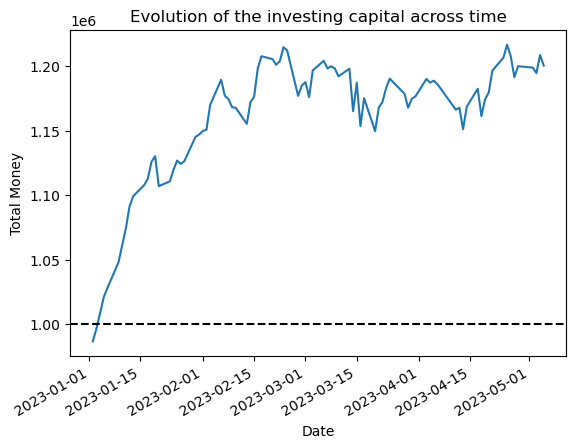

In [ ]:
sums = {}
for date, value in trading_history_dummy.items():
    sums[date] = sum(value.values())

df = pd.DataFrame.from_dict(sums, orient='index', columns=['sum'])
df.index = pd.to_datetime(df.index)
ax = df.plot(kind='line', y='sum', legend=None)
ax.axhline(y=1000000, linestyle='--', color='black')
plt.xlabel('Date')
plt.ylabel('Total Money')
plt.title('Evolution of the investing capital across time')
plt.show()

### 5.2 XGBoost

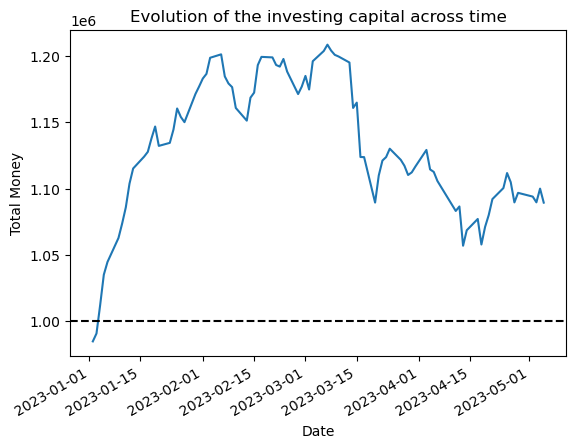

In [ ]:
sums = {}
for date, value in trading_history_xgboost.items():
    sums[date] = sum(value.values())

df = pd.DataFrame.from_dict(sums, orient='index', columns=['sum'])
df.index = pd.to_datetime(df.index)
ax = df.plot(kind='line', y='sum', legend=None)
ax.axhline(y=1000000, linestyle='--', color='black')
plt.xlabel('Date')
plt.ylabel('Total Money')
plt.title('Evolution of the investing capital across time')
plt.show()

### 5.3 LSTM

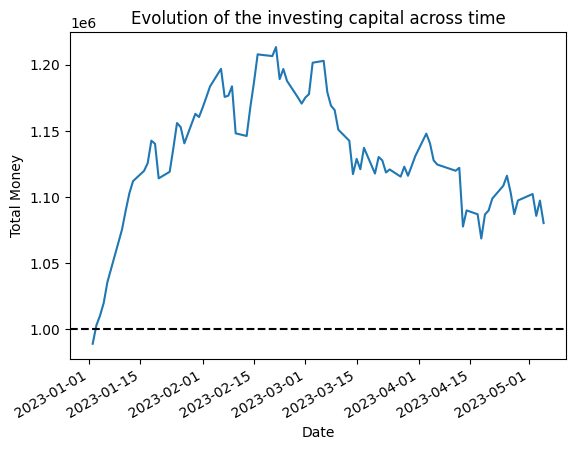

In [117]:
sums = {}
for date, value in trading_history_lstm.items():
    sums[date] = sum(value.values())

df = pd.DataFrame.from_dict(sums, orient='index', columns=['sum'])
df.index = pd.to_datetime(df.index)
ax = df.plot(kind='line', y='sum', legend=None)
ax.axhline(y=1000000, linestyle='--', color='black')
plt.xlabel('Date')
plt.ylabel('Total Money')
plt.title('Evolution of the investing capital across time')
plt.show()